## Predicting Pectin extraction yield from FTIR ($X_1$) and Carbohydrate Microarray ($X_2$) data

In this example we use Multiblock Partial Least Squares regression to predict the pectin extraction yield for samples which were measured on FTIR and Carbohydrate Microarrays. The aim is not only to establish prediction models, but also to investigate how much each block contributes to the prediction of the extraction yield. We recommend that you check out the FTIR and Carbohydrate Microarray notebooks prior to working on this notebook. These two notebooks elaborate on modeling pectin yield using both data sets independently.

## Load dependencies and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

# X1 part
ftir1 = pd.read_pickle('ftir1.pkl')
ftir2 = pd.read_pickle('ftir2.pkl')
ftir3 = pd.read_pickle('ftir3.pkl')
# X2 part
carb1 = pd.read_pickle('extraction1.pkl')
carb2 = pd.read_pickle('extraction2.pkl')
carb3 = pd.read_pickle('extraction3.pkl')

## Merge all dataframes across the sample dimension
To get started with our MBPLS modeling we merge all dataframes across the sample dimension, meaning that extractions 1, 2 and 3 are merged for FTIR ($X_1$), Carbohydrate Microarray ($X_2$) and pectin yield ($Y$) data.

In [2]:
x1 = pd.concat((ftir1, ftir2, ftir3))
x2 = pd.concat((carb1, carb2, carb3))
x2.index = x1.index
y = np.array(x2.index)
x1x2 = pd.concat((x1, x2), axis=1)

## Find number of latent variables using leave-one-out Cross Validation
To find the right number of latent variables (LV) we perform cross validation. Scikit learn makes it easy for us using the cross_val_predict function. We simply re-model the data using different numbers of latent variables and plot the result of the resulting Mean Square Errors (MSE). We pick the number of latent variables where the MSE is minimal to avoid overfitting and to induce as much complexity into our model as to obtained best possible results.

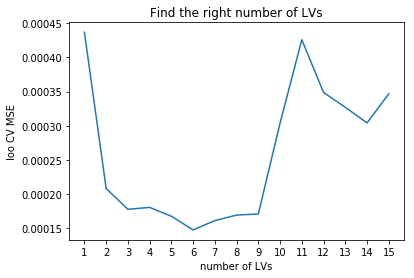

In [3]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

MSEs = []
for lv in range(15):
    mbpls = MBPLS(n_components=lv+1)
    prediction = cross_val_predict(mbpls, x1x2, y, cv=len(x1x2))
    prediction = pd.DataFrame(prediction)
    MSEs.append(mean_squared_error(prediction, y))

plt.plot(np.arange(1,16), MSEs)
plt.xlabel('number of LVs')
plt.xticks(np.arange(1,16), np.arange(1,16))
plt.ylabel('loo CV MSE')
plt.title('Find the right number of LVs');

## Plot resulting calibration curve and evaluate model 
Our plot above indicates that 3 LVs are necessary to establish our MBPLS model. We choose 3 instead of 6 LVs to avoid from overfitting due to the small sample size. We re-model using 3 LVs and plot the resulting calibration to evaluate the mean square prediction error (MSE) of cross validation. 

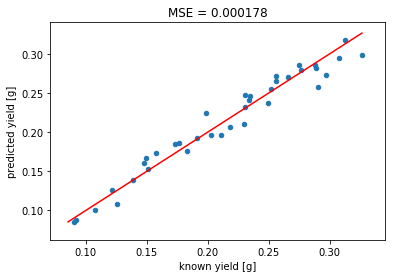

In [4]:
from mbpls.mbpls import MBPLS
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

mbpls = MBPLS(n_components=3)
prediction = cross_val_predict(mbpls, x1x2, y, cv=len(x1x2))
prediction = pd.DataFrame(prediction)
y = pd.DataFrame(y)
prediction = pd.concat((prediction, y), axis=1)
prediction.columns=['predicted yield [g]', 'known yield [g]']
prediction.plot.scatter(x='known yield [g]', y='predicted yield [g]')
plt.plot([prediction.min().min(), prediction.max().max()], [prediction.min().min(), prediction.max().max()], color='red')
plt.title('MSE = %.6f' % mean_squared_error(prediction['known yield [g]'], prediction['predicted yield [g]']));

## Interpret Multiblock PLS model
Up to now we have done nothing different than prediction modeling. Although we have used MBPLS the solution is equivalent to PLS because the feature blocks $X_1$ and $X_2$ were simply concatenated and super score deflation was applied as previously described in [ref].

Now we want to find out more about how each individual feature block contributes to the actual prediction of pectin yield. To do so we fit an MBPLS estimator as it is done using the Scikit Learn framework and look at the results using the built-in *plot* method

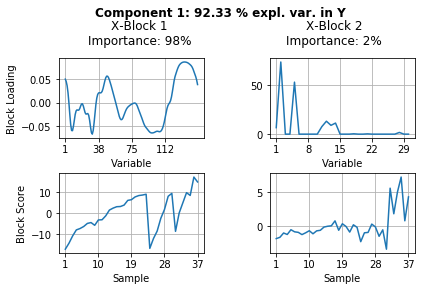

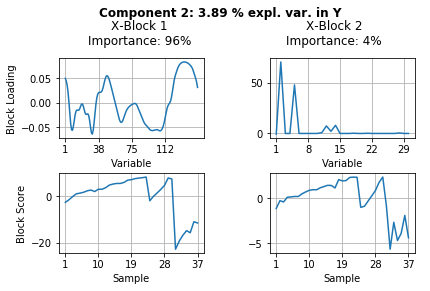

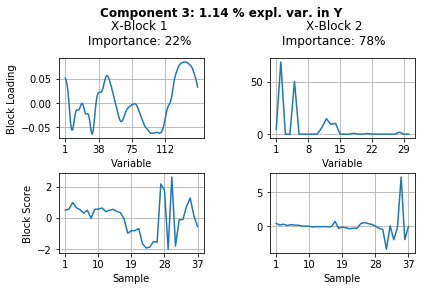

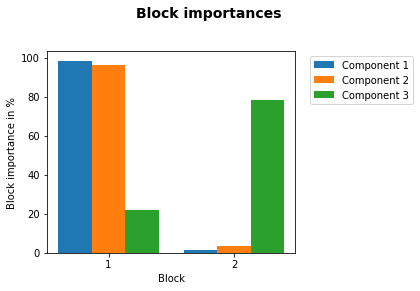

In [5]:
mbpls = MBPLS(n_components=3)
mbpls.fit(X=[x1, x2], Y=y)
# Plot results for the first num_components (LVs)
mbpls.plot(num_components=3)

The results above show a lot of information. Let's try to go through these one by one:

1.  

In [6]:
var_y = np.array(mbpls.explained_var_y_).reshape(1,-1).round(2)
bip_corrected = mbpls.A_corrected_.round(2)
BIP_corrected = pd.DataFrame(np.concatenate((bip_corrected, var_y)), 
                             columns=['LV1', 'LV2', 'LV3'], 
                             index=['FTIR', 'Carb Micr Array', 'explained variance in Y'])
BIP_corrected

,LV1,LV2,LV3
FTIR,0.93,0.85,0.05
Carb Micr Array,0.07,0.15,0.95
explained variance in Y,0.92,0.04,0.01
